# Assignment 9: PyTorch

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:


Jonas Lammert 3149269

Alexander Tiessen 2965198

Patrick Schneefuss 2951267


**If you wish to present any of the tasks, please tell us here.**
We only need to present one more task, so we would really like to present either task 1 or task 2 of this assignment.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import skimage  # Package name: scikit-image, requires installation of package 'Pillow'
import skimage.io
import skimage.transform
import torch  # Package name: torch (for pip), pytorch (for conda)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [6]:
def load_airfoil_dataset():
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    data = np.genfromtxt('airfoil_self_noise.csv')
    X, y = data[:, :5], data[:, 5]
    y = y.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

    scaler_X = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(y_train)
    X_train = scaler_X.transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.transform(y_train)
    y_test = scaler_y.transform(y_test)
    
    return X_train, X_test, y_train, y_test


def load_traffic_sign_dataset():
    import os
    
    def load_data(directory):
        directories = [d for d in os.listdir(directory)
                       if os.path.isdir(os.path.join(directory, d))]
        labels = []
        images = []
        for d in directories:
            label_directory = os.path.join(directory, d)
            file_names = [os.path.join(label_directory, f)
                          for f in os.listdir(label_directory)
                          if f.endswith(".ppm")]
            for f in file_names:
                images.append(skimage.io.imread(f))
                labels.append(int(d))
        images, labels = np.array(images), np.array(labels)
        images = np.array([skimage.transform.resize(img, (50, 50)) for img in images])
        return images, labels
            
    X_train, y_train = load_data('BelgiumTSC_Training/Training')
    X_test, y_test = load_data('BelgiumTSC_Testing/Testing')
    
    return X_train, X_test, y_train, y_test


In [7]:
class BasicDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]

    
class FlattenedImageDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = np.array([img.flatten() for img in X])
        self.y = y
        
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]


## Task 1: Linear Regression with SGD in PyTorch

In this first task, you will implement a linear regression model in PyTorch without using the existing [`torch.nn.Linear`](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) module. Instead use basic math operations such as addition and matrix multiplication for the computation of the forward pass. The computation of gradients and performing backpropagation will be automatically handled by PyTorch.

Initialize the weights and bias of the linear model using the standard Gaussian distribution similar to Assignment 8 - Task 3. The `bias` parameter selects whether a bias term should be included in the model.

*Hint:* To allow training of the network, the weights of the model have to be made trainable. A convenient way to do this is to instantiate the learnable parameters as [`torch.nn.Parameter`](https://pytorch.org/docs/master/generated/torch.nn.parameter.Parameter.html) objects and set them as fields of a [`torch.nn.Module`](https://pytorch.org/docs/master/generated/torch.nn.Module.html) subclass.

In [8]:
class MyLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias

        # Your initialization code comes here.
        self.weights = torch.nn.Parameter(torch.randn([self.out_features,self.in_features],requires_grad=True))
        if self.bias:
            self.b = torch.nn.Parameter(torch.randn(self.out_features,requires_grad=True))
        #print(self.weights.size())
        #print(self.b.size())
       

    def forward(self, X):
        # The forward pass of the linear regression comes here.
        if self.bias:
            return torch.mm(X,self.weights.t())  + self.b
        else:
            return torch.mm(X,self.weights.t())
        


We provide you with the necessary code to train and compare your model and the reference implementation of PyTorch. You will have to replicate similar training code for multi-class classification in Task 2.

In [9]:
from sklearn.linear_model import LinearRegression

# Define hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 25
in_features = 5
out_features = 1

# Initialize models.
my_linear = MyLinear(in_features, out_features)
pt_linear = nn.Linear(in_features, out_features)

# Load dataset.
X_train, X_test, y_train, y_test = load_airfoil_dataset()
dataset_train = BasicDataset(X_train, y_train)


def train_model(model, dataset, learning_rate, batch_size, epochs): 
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Train linear model using SGD on mini-batches.
    for epoch in range(epochs):
        # DataLoader generates random batches from a given dataset.
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
         # We want to report the training loss after each epoch
        epoch_loss = 0.0 

        for batch in data_loader:
            # After each iteration of the training step, reset the local gradients stored in the network to zero.
            model.zero_grad()
            model.zero_grad()

            # Compute the forward pass.
            # Numpy uses doubles by default but Torch expects floats, since the added accuracy of doubles 
            # is generally not useful for neural networks.
            # We fix this issue by changing the datatype of 'X' and 'y' with the .float method.
            yhat = model.forward(batch['X'].float())

            # Compute the batch error.
            batch_loss = F.mse_loss(yhat, batch['y'].float())
            epoch_loss += batch_loss.item()
            
            # Backpropagate the gradient and adjust the weights.
            batch_loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')

        
def evaluate_model(model, X_test, y_test):
    X_test = torch.from_numpy(X_test).float()    
    yhat = model.forward(X_test).detach().numpy()
    mse = np.mean(np.power(yhat - y_test, 2))
    print('Test MSE:', mse)
    
    
print('MyLinear')
train_model(my_linear, dataset_train, learning_rate, batch_size, epochs)
evaluate_model(my_linear, X_test, y_test)
print()
print('torch.nn.Linear')
train_model(pt_linear, dataset_train, learning_rate, batch_size, epochs)
evaluate_model(pt_linear, X_test, y_test)
print()
print('sklearn.linear_model.LinearRegression')
print('Test MSE:', np.mean(np.power(LinearRegression().fit(X_train, y_train).predict(X_test) - y_test, 2)))

MyLinear
Epoch 1/25 - Loss: 169.79103422164917
Epoch 2/25 - Loss: 97.00686264038086
Epoch 3/25 - Loss: 60.33148646354675
Epoch 4/25 - Loss: 40.18928790092468
Epoch 5/25 - Loss: 27.49724006652832
Epoch 6/25 - Loss: 20.60260397195816
Epoch 7/25 - Loss: 15.828066349029541
Epoch 8/25 - Loss: 12.906903624534607
Epoch 9/25 - Loss: 11.078743934631348
Epoch 10/25 - Loss: 10.058132946491241
Epoch 11/25 - Loss: 9.349105417728424
Epoch 12/25 - Loss: 8.739380866289139
Epoch 13/25 - Loss: 8.629709482192993
Epoch 14/25 - Loss: 8.181325316429138
Epoch 15/25 - Loss: 8.101333916187286
Epoch 16/25 - Loss: 8.068651705980301
Epoch 17/25 - Loss: 7.949814021587372
Epoch 18/25 - Loss: 7.886756539344788
Epoch 19/25 - Loss: 7.7649111449718475
Epoch 20/25 - Loss: 7.92367622256279
Epoch 21/25 - Loss: 7.93308399617672
Epoch 22/25 - Loss: 7.9199360609054565
Epoch 23/25 - Loss: 7.7965036034584045
Epoch 24/25 - Loss: 7.807847321033478
Epoch 25/25 - Loss: 7.901336044073105
Test MSE: 0.46123431228629774

torch.nn.Line

## Task 2: Image Classification with FNN

In this task, you will implement an FNN for multi-class classification of traffic signs.

Download the [training](https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip) and [test](https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip) data. Unpack the zip-files in the same directory as the Jupyter notebook.

The shape of each image is `(width=50, height=50, channels=3)` after resizing. The channels represent the color of each pixel.
FNN cannot directly operate on images. We therefore have to flatten each image to a vector.
We achieve this with the [`numpy.flatten`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) method. The class `FlattenedImageDataset` may be used for training of your FNN.

Implement a feedforward neural network with multiple layers using either [`nn.Sequential`](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html) class or by subclassing [`nn.Module`](https://pytorch.org/docs/master/generated/torch.nn.Module.html) as shown in Task 1.  Use a combination [`nn.Linear`](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) and activation functions (e.g. [`nn.ReLU`](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html)) to implement the fully connected layers of an FNN. Experiment with different activation functions (ReLU, tanh, ...), different depths, and widths. Use the Adam optimizer ([`optim.Adam`](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam)) for optimization.

You should evaluate your model by at least computing the relevant metrics (e.g. F1-score) and looking at a few misclassified samples.

*Note:* You may modify the code from Task 1. However, you need to use an appropriate loss function and output layer for your FNN to train your network for multi-class classification. Use your knowledge from the lecture to identify the correct methods in the [PyTorch documentation](https://pytorch.org/docs/stable/index.html).

In [10]:
# Load training and testing data.
X_train, X_test, y_train, y_test = load_traffic_sign_dataset()
print('Training samples:', X_train.shape[0])
print('Testing samples:', X_test.shape[0])
print('Image shape:', X_train[0].shape)
print('#Classes:', len(np.unique(y_train)))

/home/patrick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Training samples: 4575
Testing samples: 2520
Image shape: (50, 50, 3)
#Classes: 62


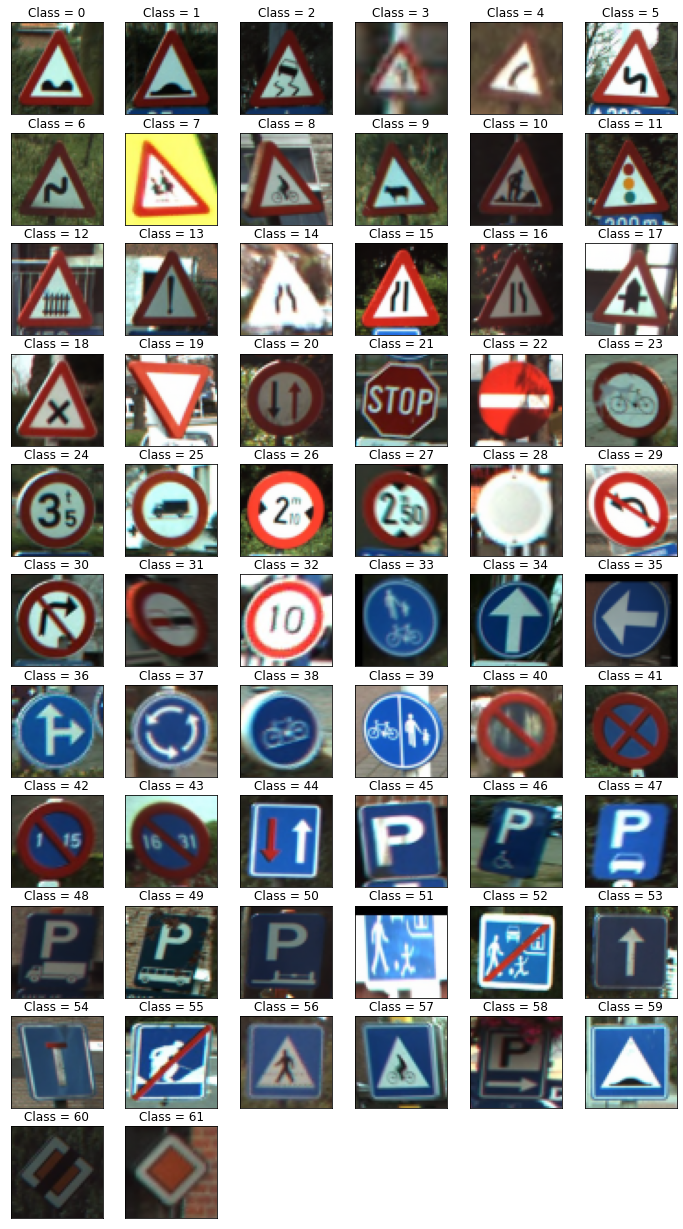

In [11]:
# Show sample for each class.
class_labels = set(np.unique(y_train))
n_classes = len(class_labels)

n_cols = 6
n_rows = n_classes // n_cols + 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
for label in sorted(class_labels):
    row = label // n_cols
    col = label % n_cols
    img_idx = np.argmax(y_train == label)
    ax[row, col].imshow(X_train[img_idx])
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    ax[row, col].set_title(f'Class = {label}')
    
leftover_subplots = n_cols - (max(class_labels) % n_cols) - 1
for i in range(leftover_subplots):
    fig.delaxes(ax[-1, -(i+1)])

In [23]:
# Implement your model and training here.
class MyFNN(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        #self.in_features = in_features
        #self.out_features = out_features
        self.linear1 = nn.Linear(in_features,2500)        
        self.linear2 = nn.Linear(2500,1024)
        self.linear3 = nn.Linear(1024,512)
        self.linear4 = nn.Linear(512,256)
        self.linear5 = nn.Linear(256, 128)
        self.linear6 = nn.Linear(128, out_features)
       

    def forward(self, X):
       
        out = self.linear1(X)
        out = F.relu(out)        
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)    
        out = self.linear4(out)
        out = F.relu(out)    
        out = self.linear5(out)
        out = F.relu(out)
        out = self.linear6(out)       
        #out = F.relu(out)            
        return out


        

/home/patrick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
MyFNN
Epoch 1/51 - Loss: 791.863527059555
Epoch 2/51 - Loss: 191.7306580543518
Epoch 3/51 - Loss: 151.47699785232544
Epoch 4/51 - Loss: 125.14670395851135
Epoch 5/51 - Loss: 106.17748069763184
Epoch 6/51 - Loss: 101.55193710327148
Epoch 7/51 - Loss: 92.63530403375626
Epoch 8/51 - Loss: 87.40189528465271
Epoch 9/51 - Loss: 82.14597314596176
Epoch 10/51 - Loss: 88.85515987873077
Epoch 11/51 - Loss: 91.29651701450348
Epoch 12/51 - Loss: 80.12487971782684
Epoch 13/51 - Loss: 74.61616396903992
Epoch 14/51 - Loss: 67.03233808279037
Epoch 15/51 - Loss: 65.75635462999344
Epoch 16/51 - Loss: 73.74985426664352
Epoch 17/51 - Loss: 65.03453609347343
Epoch 18/51 - 

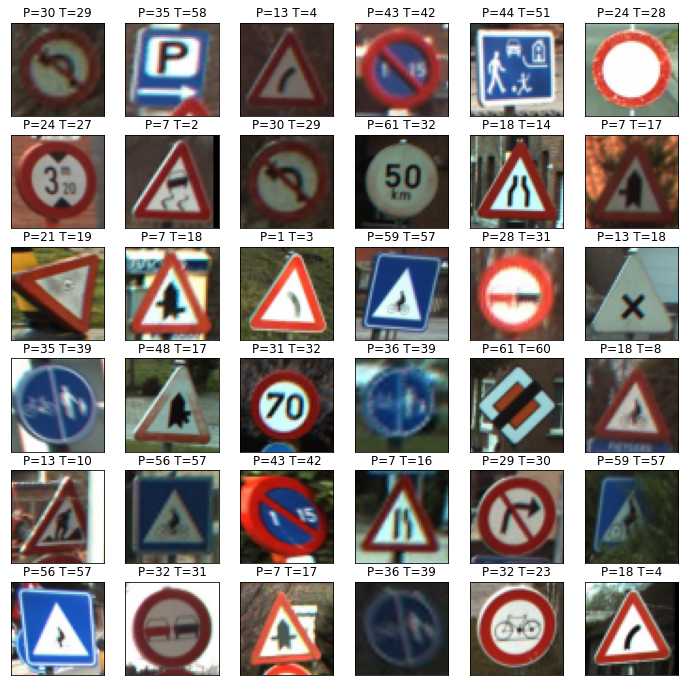

In [24]:
# Implement your evaluation here.


# Define hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 51
in_features = 50 * 50 * 3
out_features = 62

# Initialize models.
my_fnn = MyFNN(in_features, out_features)

# Load dataset.
X_train, X_test, y_train, y_test = load_traffic_sign_dataset()
dataset_train = FlattenedImageDataset(X_train, y_train)
X_test_flat =  np.array([img.flatten() for img in X_test])

def train_model(model, dataset, learning_rate, batch_size, epochs): 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        # DataLoader generates random batches from a given dataset.
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
         # We want to report the training loss after each epoch
        epoch_loss = 0.0 
        for batch in data_loader:          
                                  
            yhat = model.forward(batch['X'].float())                      
            
            # Compute the batch error.
            batch_loss = F.cross_entropy(yhat, batch['y'].long())
            epoch_loss += batch_loss.item()            
            batch_loss.backward()       
            optimizer.step()
            model.zero_grad()       
        
        # Only print every tenth epoch for visual clarity
        #if ((epoch+1)%5 == 1):
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')


def evaluate_model(model, X, y):
    from sklearn.metrics import f1_score
    # Generate Predicitions       
    X_test_flat = torch.from_numpy(X).float()  
    y = torch.from_numpy(y).long()  
    yhat = model.forward(X_test_flat)
    # Calculate Cross Entropy for Test Data
    loss = F.cross_entropy(yhat, y)
    yhat = F.softmax(yhat, dim=1)
    print(f"Testing Cross Entropy: {loss}")
    _, pred_y = torch.max(yhat,1)
    pred_y = pred_y.detach().numpy()
    # Calculate F1 scores
    f1_micro = f1_score(y, pred_y, average='micro')
    f1_macro = f1_score(y, pred_y, average='macro')
    f1_weighted = f1_score(y, pred_y, average='weighted')
    print(f"F1 micro: {f1_micro}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 weighted: {f1_weighted}")
    # Evaluate correct and wrong classifications
    inspect_misclassifications(pred_y, y.detach().numpy(), X_test)

def inspect_misclassifications(y_pred,y_true,X_test):
    print(f"Testing samples: {len(y_true)}")    
    print(f"Correct Predictions: {(y_pred == y_true).sum()}")

    wrong_ids = np.where(y_pred!=y_true)[0]
    np.random.shuffle(wrong_ids)
    print(wrong_ids)
    n_cols = 6
    n_rows = 6
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
    for i in range(36):      
        
        row = int(i / n_cols)
        col = i % n_cols
        img_idx = wrong_ids[i]
        ax[row, col].imshow(X_test[img_idx])
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        ax[row, col].set_title(f'P={y_pred[img_idx]} T={y_true[img_idx]}')    

    
    

print('MyFNN')
train_model(my_fnn, dataset_train, learning_rate, batch_size, epochs)
evaluate_model(my_fnn, X_test_flat, y_test)  




## Task 3: Image Classification with CNN

*For all students other than B.Sc. Data Science.*

In this task, you will implement a convolutional neural network (CNN) for classification of traffic signs.
Your model should use [`nn.Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) layers to compute convolutions, any kind of pooling (e.g. [`nn.MaxPool2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d)), and a dense output network.
For inspiration look at the architecture of AlexNet (presented in the lecture).
For simplicity, you may use the `nn.Sequential` class.

You should evaluate your model by at least computing the relevant metrics (e.g. F1-score) and looking at a few misclassified samples.

*Note:* For the most part, you can reuse your code from Task 2. However, you have to use images in their original format `(128, 128, 3)` instead of the flattened shape.

In [25]:
# Implement your model and training here.

In [26]:
# Implement your evaluation here.